In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import partial_dependence
import os
pd.set_option("display.max_columns", None) # pd.reset_option("display.max_columns")

In [4]:
project_path = r'C:\Users\cneva\Projects\NBA Shot Analysis\Datasets'
df = pd.read_csv(os.path.join(project_path,'shot_logs.csv'))

In [7]:
df = \
(df
 .drop(["CLOSEST_DEFENDER_PLAYER_ID", "GAME_ID", "player_name", "player_id"], axis = 1)
 .assign(
     MONTH = pd.to_datetime(df.MATCHUP.str.split(" - ", n = 1, expand = True)[0]).dt.month, # Extracted from Matchup
     HOME_TEAM = df.MATCHUP.str.split("- ", expand = True)[1].str.split(" @ ", expand = True)[1], # Inbetween column to TEAM/OPPOSING_TEAM
     AWAY_TEAM = df.MATCHUP.str.split("- ", expand = True)[1].str.split(" @ ", expand = True)[0], # Inbetween column to TEAM/OPPOSING_TEAM
     TEAM = lambda df: np.where(df.LOCATION == "A", df.AWAY_TEAM, df.HOME_TEAM), # Team/Opposing team extracted from Matchup
     OPPOSING_TEAM = lambda df: np.where(df.LOCATION == "H", df.AWAY_TEAM, df.HOME_TEAM), # Team/Opposing team extracted from Matchup
     PERIOD_CLOCK = lambda df: pd.to_datetime(df.GAME_CLOCK, format = "%M:%S").dt.minute * 60 + pd.to_datetime(df.GAME_CLOCK, format = "%M:%S").dt.second, # Convert Timer
     SHOT_RESULT = lambda x: pd.get_dummies(x["SHOT_RESULT"])["made"].astype("bool").equals(x["FGM"].astype("bool"))
 )
 .drop(["MATCHUP", "HOME_TEAM", "AWAY_TEAM", "GAME_CLOCK", "SHOT_RESULT", "PTS", "W"], axis = 1) # Drop unnecessary columns
)

df.sample(5)

C:\Users\cneva\AppData\Local\Temp\ipykernel_6048\3220874471.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MONTH = pd.to_datetime(df.MATCHUP.str.split(" - ", n = 1, expand = True)[0]).dt.month, # Extracted from Matchup


,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSE_DEF_DIST,FGM,MONTH,TEAM,OPPOSING_TEAM,PERIOD_CLOCK
59113,H,6,3,2,8.6,4,3.0,4.2,2,"Henson, John",1.5,1,1,None,SAS vs. MIL,464
35861,A,-3,26,4,NaN,12,9.8,7.3,2,"Pondexter, Quincy",2.3,1,1,DAL,NOP,14
47670,H,4,8,3,24.0,0,0.1,1.7,2,"Garnett, Kevin",0.0,0,12,None,CLE vs. BKN,485
45681,H,-23,3,2,20.6,0,0.6,5.0,2,"Butler, Caron",2.3,0,12,None,CLE vs. DET,394
2188,H,-28,13,4,18.9,3,4.7,4.2,2,"Drummond, Andre",2.1,1,2,None,CHA vs. DET,377


In [57]:
df.columns

Index(['LOCATION', 'FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD', 'SHOT_CLOCK',
       'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSEST_DEFENDER',
       'CLOSE_DEF_DIST', 'FGM', 'MONTH', 'TEAM', 'OPPOSING_TEAM',
       'PERIOD_CLOCK'],
      dtype='object')

In [65]:
df_ml = \
(df
 .assign(SHOT_CLOCK = lambda df: df.SHOT_CLOCK.fillna(df.SHOT_CLOCK.mean(), inplace = True))
 .loc[:,['FINAL_MARGIN', 'CLOSE_DEF_DIST', 'SHOT_DIST', 'PTS_TYPE', 'TOUCH_TIME', 'PERIOD', 'SHOT_CLOCK', 'SHOT_NUMBER', 'DRIBBLES']]
 # 'LOCATION','CLOSEST_DEFENDER','FGM', 'MONTH', 'TEAM', 'OPPOSING_TEAM','PERIOD_CLOCK'
)

X_ = df_ml.drop("FGM", axis = 1)
y_ = df_ml["FGM"]
X_train, X_test, y_train, y_test = train_test_split(X_, 
                                                    y_, 
                                                    test_size = 0.3, 
                                                    random_state = 123)

C:\Users\cneva\AppData\Local\Temp\ipykernel_6048\211053576.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  .assign(SHOT_CLOCK = lambda df: df.SHOT_CLOCK.fillna(df.SHOT_CLOCK.mean(), inplace = True))


In [12]:
cv_model = ( \
    GridSearchCV(
        GradientBoostingClassifier(random_state = 123), 
        param_grid={"learning_rate": np.logspace(-3, -1, 3)}
    ).fit(X_train, y_train)
    
cv_model.best_params_

{'learning_rate': 0.1}

In [13]:
model = GradientBoostingClassifier(random_state = 123).fit(X_train, y_train)
model.score(X_test, y_test)

0.6188802998360272

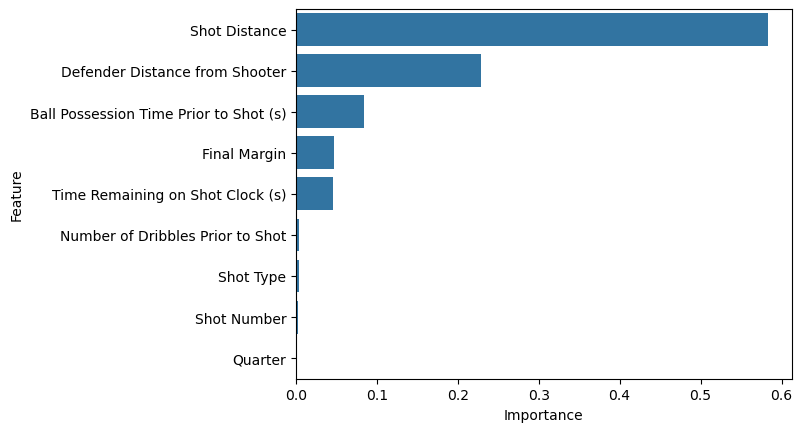

In [19]:
features = X_train.columns
feature_significance = pd.DataFrame({"Feature": features, 
                                     "Importance": model.feature_importances_})
feature_significance.sort_values("Importance", 
                                 ascending=False, 
                                 inplace=True)
feature_significance.reset_index(drop=True, inplace=True)
feature_significance.index += 1
feature_significance.at[1, "Feature"] = "Shot Distance"
feature_significance.at[2, "Feature"] = "Defender Distance from Shooter"
feature_significance.at[3, "Feature"] = "Ball Possession Time Prior to Shot (s)"
feature_significance.at[4, "Feature"] = "Final Margin"
feature_significance.at[5, "Feature"] = "Time Remaining on Shot Clock (s)"
feature_significance.at[6, "Feature"] = "Number of Dribbles Prior to Shot"
feature_significance.at[7, "Feature"] = "Shot Type"
feature_significance.at[8, "Feature"] = "Shot Number"
feature_significance.at[9, "Feature"] = "Quarter"
ax = sns.barplot(x = feature_significance["Importance"], y = feature_significance["Feature"], orient="h")